<a href="https://colab.research.google.com/github/adammoss/MLiS2/blob/master/examples/rnn/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import csv
import itertools
import operator
import numpy as np
import nltk
import sys
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

Download NLTK data

In [0]:
%%capture
nltk.download("book")

Upload deep_learning_sentences.txt file (or another file containing a list of sentences if you wish)

In [193]:
from google.colab import files
uploaded = files.upload()

Saving deep_learning_sentences.txt to deep_learning_sentences (1).txt


Add sentence start and end tags, convert to lower case and strip newlines

In [0]:
sentence_start_token = "SENTENCE_START"
sentence_end_token = "SENTENCE_END"

In [0]:
with open('deep_learning_sentences.txt', 'r') as f:
  sentences = f.readlines()
sentences = ["%s %s %s" % (sentence_start_token, x.lstrip().rstrip('.\n').lower(), sentence_end_token) for x in sentences]

In [361]:
print("Parsed %d sentences." % (len(sentences)))
for i in range(0, 10):
  print("Example: %s" % sentences[i])

Parsed 7674 sentences.
Example: SENTENCE_START part ii  deep networks: modern  practices  166    this part of the book summarizes the state of modern deep learning as it is used to solve practical applications SENTENCE_END
Example: SENTENCE_START this part focuses only on those approaches that are essentially working tech- nologies that are already used heavily in industry SENTENCE_END
Example: SENTENCE_START by adding more layers and more units within a layer, a deep network can represent functions of increasing complexity SENTENCE_END
Example: SENTENCE_START most tasks that consist of mapping an input vector to an output vector, and that are easy for a person to do rapidly, can be accomplished via deep learning, given sufficiently large models and sufficiently large datasets of labeled training examples SENTENCE_END
Example: SENTENCE_START other tasks, that can not be described as associating one vector to another, or that are difficult enough that a person would require time to thin

Tokenize the sentences into words

In [0]:
tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]

In [363]:
word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
print("Found %d unique words tokens." % len(word_freq.items()))

Found 13509 unique words tokens.


In [0]:
vocab_size = 1000
unknown_token = 'UNKNOWN_TOKEN'

In [0]:
vocab = word_freq.most_common(vocab_size-1)
index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)
word_to_index = dict([(w,i) for i, w in enumerate(index_to_word)])

Replace all words not in our vocabulary with the unknown token and discard sentences under min / over max number of words

In [0]:
min_sentence_length = 10
max_sentence_length = 20

In [0]:
purged_sentences = []
for i, sent in enumerate(tokenized_sentences):
  if min_sentence_length <= len(sent) <= max_sentence_length:
    purged_sentences.append([w if w in word_to_index else unknown_token for w in sent])

In [371]:
print("Purged %d sentences." % (len(purged_sentences)))
for i in range(0, 10):
  print("Example: %s" % purged_sentences[i])

Purged 800 sentences.
Example: ['SENTENCE_START', 'scaling', 'these', 'models', 'to', 'large', 'inputs', 'such', 'as', 'high', 'UNKNOWN_TOKEN', 'images', 'or', 'long', 'UNKNOWN_TOKEN', 'sequences', 'requires', 'UNKNOWN_TOKEN', 'SENTENCE_END']
Example: ['SENTENCE_START', 'feedforward', 'neural', 'networks', 'are', 'called', 'networks', 'because', 'they', 'are', 'typically', 'represented', 'by', 'UNKNOWN_TOKEN', 'together', 'many', 'different', 'functions', 'SENTENCE_END']
Example: ['SENTENCE_START', 'the', 'model', 'is', 'UNKNOWN_TOKEN', 'UNKNOWN_TOKEN', 'with', 'a', 'directed', 'UNKNOWN_TOKEN', 'graph', 'describing', 'how', 'the', 'functions', 'are', 'UNKNOWN_TOKEN', 'together', 'SENTENCE_END']
Example: ['SENTENCE_START', 'this', 'general', 'principle', 'of', 'UNKNOWN_TOKEN', 'models', 'by', 'learning', 'features', 'UNKNOWN_TOKEN', 'UNKNOWN_TOKEN', 'the', 'feedforward', 'networks', 'described', 'in', 'this', 'chapter', 'SENTENCE_END']
Example: ['SENTENCE_START', 'feedforward', 'network

Create the training data

In [0]:
X_train = np.asarray([[word_to_index[w] for w in sent[:-1]] for sent in purged_sentences])
Y_train = np.asarray([[word_to_index[w] for w in sent[1:]] for sent in purged_sentences])

Limit to 100 training examples to save time

In [0]:
X_train = X_train[0:100]
Y_train = Y_train[0:100]

In [374]:
print("Example: ", X_train[2])

Example:  [2, 0, 25, 9, 999, 999, 17, 8, 337, 999, 142, 755, 112, 0, 127, 23, 999, 754]


In [0]:
def softmax(x):
    xt = np.exp(x - np.max(x))
    return xt / np.sum(xt)

In [0]:
class RNN:
    
  def __init__(self, word_dim, hidden_dim=100):
      # Assign instance variables
      self.word_dim = word_dim
      self.hidden_dim = hidden_dim
      # Randomly initialize the network parameters
      self.U = np.random.uniform(-np.sqrt(1./word_dim), np.sqrt(1./word_dim), (word_dim, hidden_dim))
      self.V = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, word_dim))
      self.W = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, hidden_dim))
      self.b = np.zeros(hidden_dim)
      self.c = np.zeros(word_dim)

  def forward(self, x):
    # Do a forward pass for single example
    T = len(x)
    h = np.zeros((T , self.hidden_dim))
    o = np.zeros((T, self.word_dim))
    for t in range(T):
      # Note that we are indexing U by x[t]. This is the same as multiplying U with a one-hot vector.
      if t == 0:
        h[t] = self.U[x[t], :] + self.b
      else:
        h[t] = np.matmul(self.W.T, h[t-1]) + self.U[x[t], :] + self.b
      o[t] = softmax(np.matmul(self.V.T, h[t]) + self.c)
    return (o, h)

  def backward(self, x, y):
    #Do a backward pass for single example
    T = len(x)
    o, h = self.forward(x)
    # Accumulate the gradients in these variables
    dLdU = np.zeros(self.U.shape)
    dLdV = np.zeros(self.V.shape)
    dLdW = np.zeros(self.W.shape)
    dLdb = np.zeros(self.b.shape)
    dLdc = np.zeros(self.c.shape)
    # dL/do
    delta_o = o
    delta_o[np.arange(len(y)), y] -= 1.
    # dL/dh
    delta_h = np.zeros((T, self.hidden_dim))
    for t in reversed(range(T)):
      if t == T - 1:
        delta_h[t] = np.matmul(self.V, delta_o[t, :])
      else:
        delta_h[t] = np.matmul(np.matmul(self.W, np.diag(1 - h[t+1]**2)), delta_h[t+1]) + np.matmul(self.V, delta_o[t, :])
    # Accumulate gradients over time-steps
    for t in range(T):
      dLdc += delta_o[t, :]
      dLdb += np.matmul(np.diag(1 - h[t]**2), delta_h[t, :])
      dLdV += np.outer(h[t, :], delta_o[t, :])
      #if t > 0:
      #  #dLdW += np.matmul(np.outer(h[t-1, :], delta_h[t, :]), np.diag(1 - h[t]**2))
      m = np.zeros(self.U.shape)
      m[x, :] = delta_h[t, :]
      #dLdU += np.matmul(m, np.diag(1 - h[t]**2))
    return (dLdU, dLdV, dLdW, dLdb, dLdc)

  def step(self, x, y, learning_rate=0.01):
    # Perform SGD step for single example
    dLdU, dLdV, dLdW, dLdb, dLdc  = self.backward(x, y)
    self.U -= learning_rate * dLdU
    self.V -= learning_rate * dLdV
    self.W -= learning_rate * dLdW
    self.b -= learning_rate * dLdb
    self.c -= learning_rate * dLdc

  def loss(self, x, y):
    # Per example loss
    o, h = self.forward(x)
    return - np.sum(o[np.arange(len(y)), y])

  def generate_sentence(self, max_length=20):
    # We start the sentence with the start token
    new_sentence = [word_to_index[sentence_start_token]]
    # Repeat until we get an end token or reach maximum sentence length
    while not new_sentence[-1] == word_to_index[sentence_end_token] and len(new_sentence) < max_length:
      o, h = self.forward(new_sentence)
      sampled_word = word_to_index[unknown_token]
      # We don't want to sample unknown words or sentence start
      while sampled_word == word_to_index[unknown_token] or sampled_word == word_to_index[sentence_start_token]:
          samples = np.random.multinomial(1, o[-1])
          sampled_word = np.argmax(samples)
      new_sentence.append(sampled_word)
    sentence_str = [index_to_word[x] for x in new_sentence]
    return sentence_str


In [0]:
model = RNN(vocab_size)

Generate random sentences

In [415]:
for i in range(10):
  print(model.generate_sentence())

['SENTENCE_START', 'when', 'efficient', 'sentence', '{', 'out', '•', 'now', 'exponential', '←', 'difficulty', '\ue012', 'variety', 'apply', 'for', '2', 'u', 'search', '3', 'sometimes']
['SENTENCE_START', 'based', 'part', 'however', 'consists', 'mathematical', 'shallow', 'minimizing', 'representations', 'view', 'known', '3', 'number', 'binary', ':', 'unfortunately', '0', 'derivatives', 'see', 'minibatch']
['SENTENCE_START', 'either', 'h.', 'outputs', 'longer', 'equations', 'pixel', 'too', 'specific', 'strong', 'low', 'regularized', 'compute', 'challenge', 'powerful', 'x1x1', 'been', 'structure', 'ai', 'shows']
['SENTENCE_START', 'since', 'practice', 'expression', 'throughout', 'around', 'without', 'enough', 'tensor', 'multiplication', 'random', 'logistic', 'initialize', 'numerical', 'now', 'during', 'typically', 'b', 'pmodel', 'visible']
['SENTENCE_START', 'matrix', 'appropriate', 'available', 'near', 'nearly', 'used', 'computationally', 'fully', 'element', 'numerical', 'known', 'loss',

In [0]:
num_epochs = 10
learning_rate = 0.01

In [417]:
loss_history = []
for epoch in range(num_epochs):
  loss = 0
  for i in range(len(X_train)):
    loss += model.loss(X_train[i], Y_train[i])
  loss = loss / len(X_train)
  print("Epoch {0} Loss {1}".format(epoch , loss))
  loss_history.append(loss)
  for i in range(len(X_train)):
    model.step(X_train[i], Y_train[i], learning_rate=learning_rate)
    


Epoch 0 Loss -0.017758412688260675
Epoch 1 Loss -0.5572461112594282
Epoch 2 Loss -0.5613102391660366
Epoch 3 Loss -0.5614541338647002
Epoch 4 Loss -0.5629374104213309
Epoch 5 Loss -0.5669944748072047


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in matmul
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in matmul
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in matmul
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in matmul


Epoch 6 Loss nan
Epoch 7 Loss nan
Epoch 8 Loss nan
Epoch 9 Loss nan


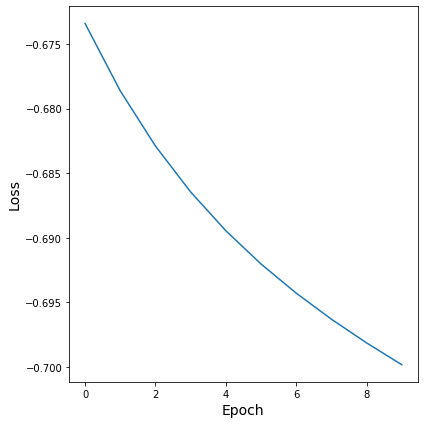

In [411]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(loss_history[:])
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
plt.tight_layout()
plt.show()

In [412]:
for i in range(10):
  print(model.generate_sentence())

['SENTENCE_START', 'of', ',', 'on', 'SENTENCE_END']
['SENTENCE_START', 'directed', 'minibatch', 'models', 'are', 'nonlinear', 'arbitrary', 'approximately', 'x1', 'approach', 'algorithm', '10', 'x', 'numerical', 'to', 'can', '5', 'are', 'pages', 'trained']
['SENTENCE_START', 'is', 'forms', 'including', 'have', 'is', 'that', 'only', 'not', 'to', 'efficient', 'the', 'therefore', 'of', 'this', 'of', 'in', 'SENTENCE_END']
['SENTENCE_START', 'SENTENCE_END']
['SENTENCE_START', 'c.', 'space', 'transformations', 'adding', 'is', 'book', 'to', 'been', 'the', 'as', 'output', 'the', 'estimates', '’', 'specify', 'the', 'most', 'sampled', 'introduced']
['SENTENCE_START', 'units', 'likely', ',', 'be', 'minibatch', ',', 'SENTENCE_END']
['SENTENCE_START', 'learning', 'later', 'model', 'of', 'large', ',', 'problems', 'equivalent', 'outputs', 'function', 'output', 'is', 'refer', 'v', 'known', 'same', 'required', 'layers', 'made']
['SENTENCE_START', 'this', 'good', 'computer', 'log', 'al', 'adversarial', '